# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
import numpy as np
from numpy import array, eye, log, zeros
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [2]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(kt['ABBREVIATION'].values, kt['KEGG ID(S)'].values))
ktaDict = dict(zip(kt['KEGG ID(S)'].values, kt['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [3]:
allRxnDf = pd.read_excel('cth_thermo_model_DO.xlsx', sheet_name = 'reactions')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,flux1,flux2,flux3,flux4
0,CBtx,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,1,1,1,1
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1
2,GLK,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1
3,PGMT,Glucose-1-phosphate <=> D-glucose-6-phosphate,g1p <=> g6p,C00103 <=> C00092,NaN,1,1,1,1
4,PGI,D-Glucose-6-phosphate <=> D-Fructose-6-phosphate,g6p <=> f6p,C00092 <=> C00085,NaN,2,2,2,2


In [4]:
# choose a flux set, and drop all of the zero-flux reactions
fluxSet = 'flux1'
selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
                                                                 # processing
selectedRxnDf

,Name,AbbreviationFormula,KeggFormula,flux
0,CBtx,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,1
1,CBP,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1
2,GLK,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,1
3,PGMT,g1p <=> g6p,C00103 <=> C00092,1
4,PGI,g6p <=> f6p,C00092 <=> C00085,2
5,PFK-PPi,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,2
7,FBA,fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,2
8,TPI,dhap <=> g3p,C00111 <=> C00118,2
9,GAPDH,pi + nad + g3p <=> nadh + 13dpg,C00009 + C00003 + C00118 <=> C00004 + C00236,4
12,PGK-GTP,gdp + 13dpg <=> gtp + 3pg,C00035 + C00236 <=> C00044 + C00197,4


In [5]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [6]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [7]:
r1 = pp.calc_mdf()

In [8]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [9]:
pp.bounds.SetBounds(atk.loc['etoh'].iloc[0], 1,1 )

In [10]:
df = bounds_to_df(pp.compound_kegg_ids, pp.bounds)
df

,Compound:Identifiers:kegg.compound,Name,Concentration:Max,Concentration:Min
0,C00001,h2o,1.00000,1.000000
1,C00002,atp,0.00500,0.005000
2,C00003,nad,0.00100,0.001000
3,C00004,nadh,0.00010,0.000100
4,C00008,adp,0.00050,0.000500
5,C00009,pi,0.01000,0.010000
6,C00010,coa,0.00100,0.001000
7,C00011,co2,0.00001,0.000010
8,C00013,ppi,0.00100,0.001000
9,C00020,amp,0.00050,0.000500


In [11]:
# calculate the min-max driving force
mdf_data = pp.calc_mdf()

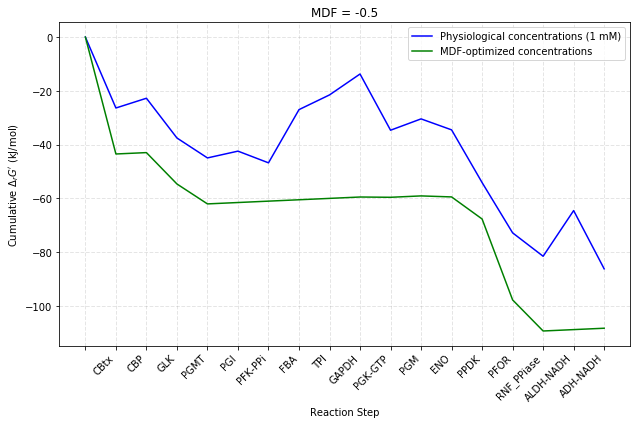

In [15]:
result = mdf_data.mdf_plot

In [14]:
result2 = mdf_data.conc_plot

IndexError: index 1 is out of bounds for axis 0 with size 1

## to-do
12-7-2018  
1. Set up function for importing bounds data from text to dataframe then to bounds object. I like the idea of working with bounds as a dataframe and then just reading the final result back to equilibrator because the dataframe gives us an easy way to review the data. Also, we can add add additional categories, like cofactors vs. carbon metabolites.
2. Set up function for putting an uncertainty factor on bounds (note, the uncertainty_factor parameter Satya used has been removed from the current version of equilibrator)
3. Make new version of plot functions to show metabolite nicknames. Try passing a name_to_cid dictionary when I make the pathway, and see if that works.
4. Make new version of conc_plot that shows the individual concentration range for each metabolite
5. [Fixed v0.1.25] Check with Elad to see when the discrepancy with dG0 for the PDC reaction has been fixed <-- need to manually calculate all dG0s for reactions involving CO2. Actually, since the dG0 values for our reactions shouldn't change, we should specify them in the model file, and then show a warning if eQuilibrator calculates different values.

In [56]:
import re
# import metabolites from excel file
metAbDf = pd.read_excel('cth_thermo_metabolites.xlsx', sheet_name = 'absolute_conc')
metAbDf['mlow'] = metAbDf['Metabolite'].str.lower()
metAbDf['mstrip'] = metAbDf['mlow'].apply(lambda x: re.sub(r'[^a-z0-9]+', '', x))
metAbDf

,Metabolite,Conc(M),mlow,mstrip
0,Glucose-6-phosphate,0.008192,glucose-6-phosphate,glucose6phosphate
1,Fructose-6-phosphate,0.001494,fructose-6-phosphate,fructose6phosphate
2,Glucose-1-phosphate,0.006663,glucose-1-phosphate,glucose1phosphate
3,Fructose 1_6-bisphosphate,0.001497,fructose 1_6-bisphosphate,fructose16bisphosphate
4,Succinate,0.000749,succinate,succinate
5,Glutamine,0.000997,glutamine,glutamine
6,Malate,0.037807,malate,malate
7,alpha-ketoglutarate,0.001403,alpha-ketoglutarate,alphaketoglutarate
8,DHAP,0.001270,dhap,dhap
9,GAP,0.000102,gap,gap


In [57]:
# import kegg IDs from equilibrator
cm = CompoundMatcher()
df = cm.compound_df
df['mstrip'] = df['lowercase_name'].apply(lambda x: re.sub(r'[^a-z0-9]+', '', x) )
df.drop(columns = ['compound_name', 'lowercase_name'], inplace = True)
df = df.drop_duplicates()
df[:5]

,CID,mstrip
0,C00001,h2o
1,C00001,h2o1
2,C00001,water
4,C00001,c00001
5,C00002,atp


In [58]:
m2Df = metAbDf.merge(df, left_on = 'mstrip', right_on = 'mstrip', how = 'left')
m2Df

,Metabolite,Conc(M),mlow,mstrip,CID
0,Glucose-6-phosphate,0.008192,glucose-6-phosphate,glucose6phosphate,C00092
1,Fructose-6-phosphate,0.001494,fructose-6-phosphate,fructose6phosphate,C00085
2,Glucose-1-phosphate,0.006663,glucose-1-phosphate,glucose1phosphate,C00103
3,Fructose 1_6-bisphosphate,0.001497,fructose 1_6-bisphosphate,fructose16bisphosphate,C05378
4,Succinate,0.000749,succinate,succinate,C00042
5,Glutamine,0.000997,glutamine,glutamine,C00064
6,Malate,0.037807,malate,malate,C00149
7,alpha-ketoglutarate,0.001403,alpha-ketoglutarate,alphaketoglutarate,NaN
8,DHAP,0.001270,dhap,dhap,NaN
9,GAP,0.000102,gap,gap,NaN


In [59]:
m2Df.to_excel('mets_kegg_IDs.xlsx')


In [36]:
df[df.lowercase_name.str.contains('sedoheptulose')]

,CID,compound_name,lowercase_name
1800,C00447,"D-Sedoheptulose-1,7-bisphosphate","d-sedoheptulose-1,7-bisphosphate"
1801,C00447,D-Sedoheptulose-bisphosphate,d-sedoheptulose-bisphosphate
1802,C00447,"Sedoheptulose-1,7-bisphosphate","sedoheptulose-1,7-bisphosphate"
1803,C00447,Sedoheptulose-bisphosphate,sedoheptulose-bisphosphate
6158,C02076,Sedoheptulose,sedoheptulose
6159,C02076,D-Sedoheptulose,d-sedoheptulose
12804,C05382,D-Sedoheptulose-7-phosphate,d-sedoheptulose-7-phosphate
12805,C05382,Sedoheptulose-7-phosphate,sedoheptulose-7-phosphate
12808,C05382,Sedoheptulose-phosphate,sedoheptulose-phosphate
12809,C05382,Sedoheptulosephosphate,sedoheptulosephosphate
